# ６章　ゲート付きRNN

前章のRNNは時系列データの長期の依存関係を上手く学習できない点において劣っている

そこで「LSTM」や「GRU」といったゲート付きのレイヤを用いる

## 6.1 RNNの問題点

RNNが時系列データの長期の依存関係を学習することが苦手な理由は

BPTT(Backpropagation Through Time)において勾配消失もしくは勾配爆発がおこるため

### 6.1.1 RNNの復習

RNNレイヤは時系列データのx_tを入力すると、h_tを出力して過去からの情報を記憶する

RNNレイヤの順伝播で行う計算は、行列の積と和、tanh関数(活性化関数)による変換

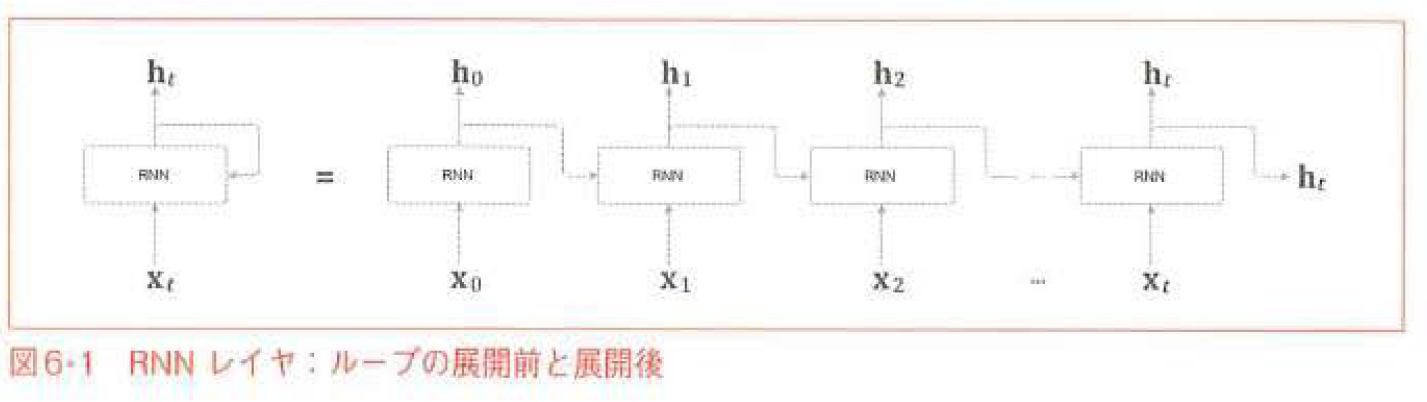

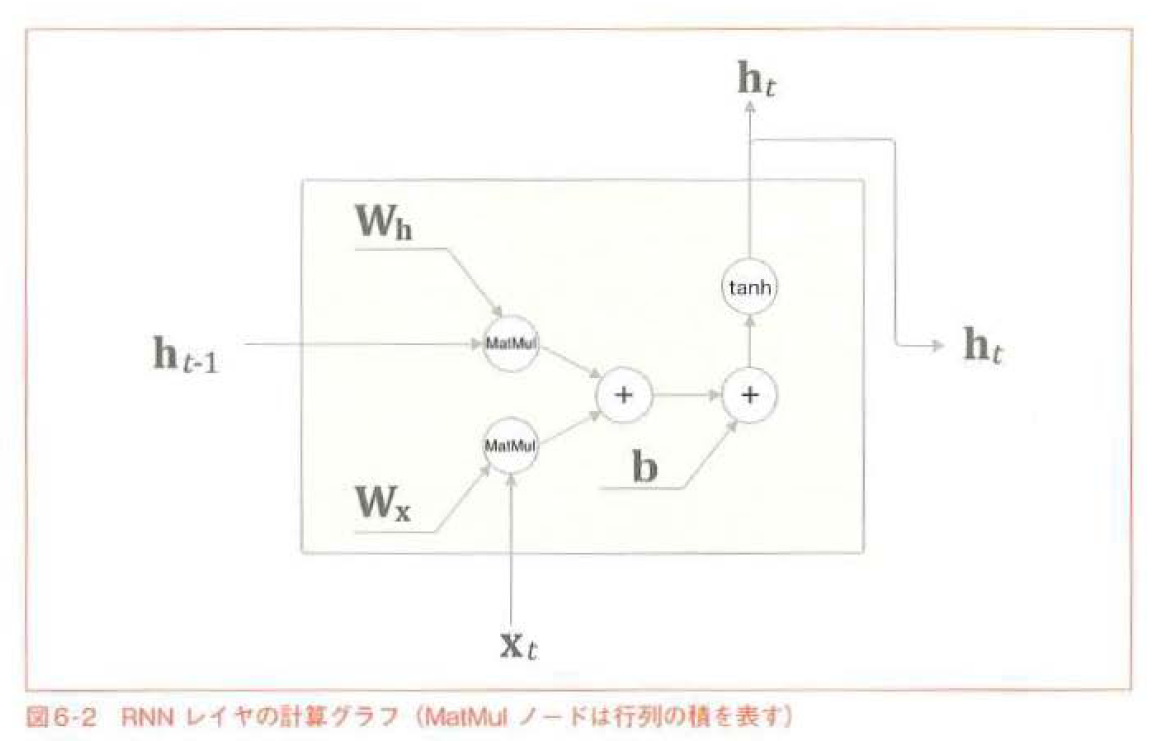

### 6.1.2 勾配消失もしくは勾配爆発

RNNレイヤが過去方向に「意味のある勾配」を伝達することで時間方向の依存関係を学習できる。

しかし、シンプルなRNNでは勾配消失もしくは勾配爆発が起こってしまう

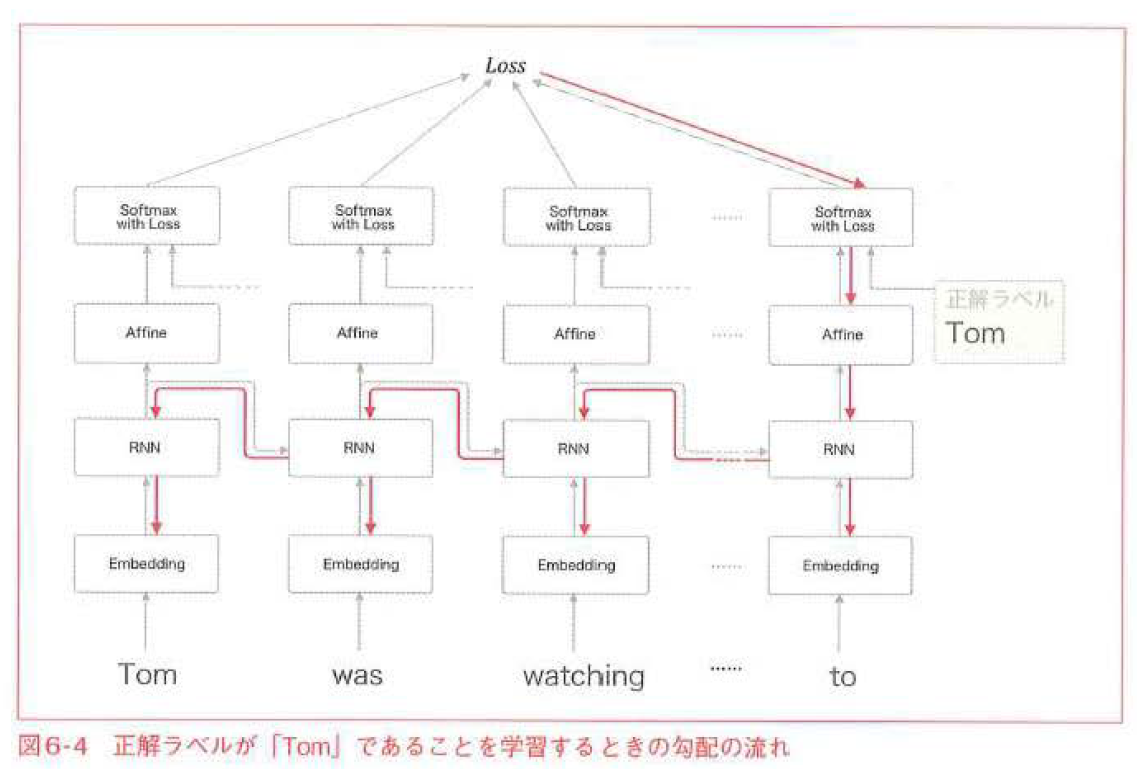

### 6.1.3 勾配消失もしくは勾配爆発の原因

RNNレイヤの時間方向だけの勾配の伝播に着目

逆伝播→「tanh」「＋」「Matmul(行列の積)」を通過

「＋」→勾配を上流から下流へただ流す

「tanh」

y=tanh(x)の微分、1-y^2は値が1.0以下で、xが0から遠ざかるにつれ値が小さくなる

よって逆伝播で勾配がtanhノードを通過する度に、値が小さくなる

「MatMul」

dhという勾配が、dh (W_h)tによる行列の積で、その時系列データの時間サイズ分、計算される

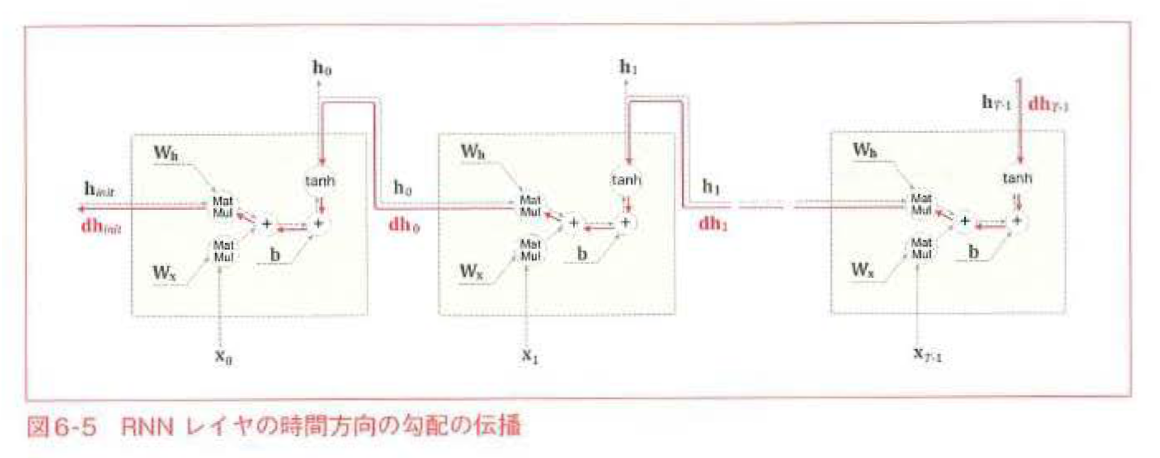

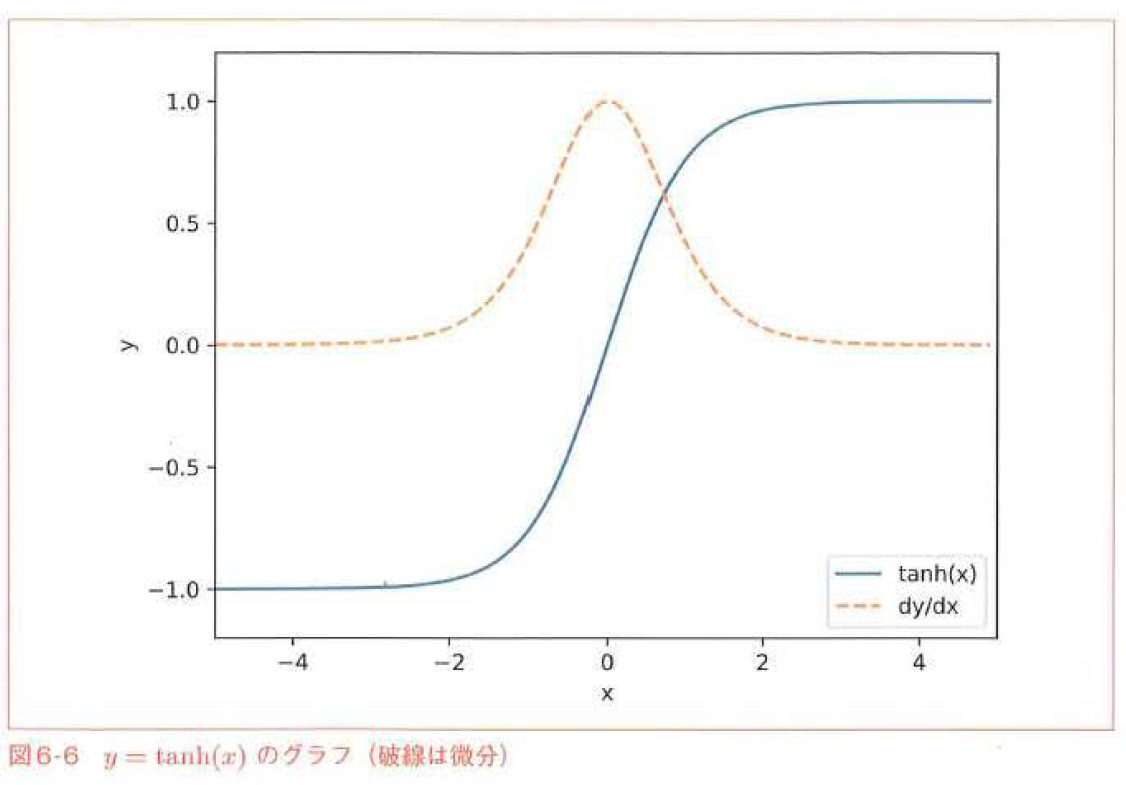

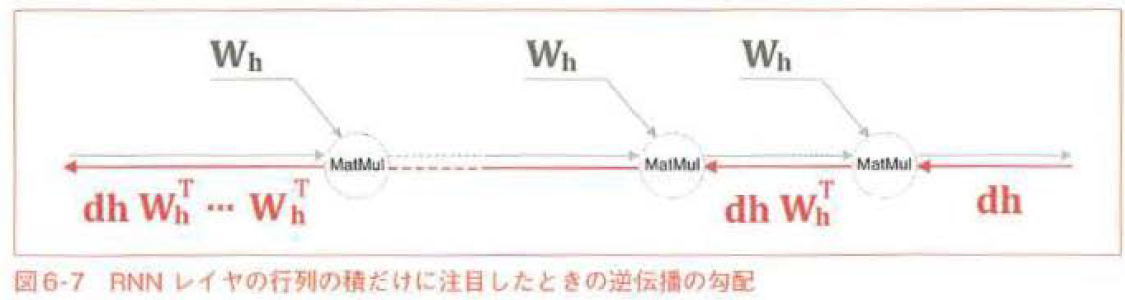

ここから実際に観察

In [1]:
import numpy as np
import matplotlib.pyplot as plt


N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


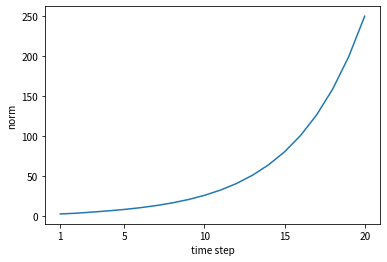

In [2]:
# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配爆発が起こっている

次にW_hの初期値を変更

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


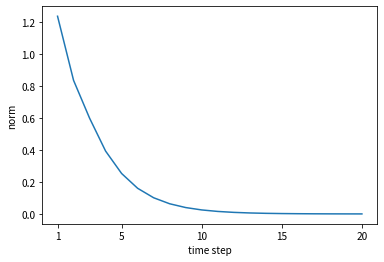

In [6]:
N = 2  # ミニバッチサイズ
H = 3  # 隠れ状態ベクトルの次元数
T = 20  # 時系列データの長さ

dh = np.ones((N, H))

np.random.seed(3)

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# グラフの描画
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

勾配消失が起こっている

### 6.1.4 勾配爆発への対策

勾配クリッピング

勾配がしきい値を超えた場合に勾配を修正する

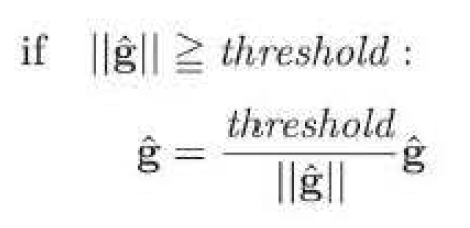

勾配クリッピングを実装

In [7]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


## 6.2 勾配消失とLSTM

勾配消失の問題を解決するために「ゲート付きRNN」を用いる

本節ではLSTMを扱う

### 6.2.1 LSTMのインターフェース

tanh(h_t-1×Ｗ_h＋x_t×Ｗ_x＋b)

という計算を長方形ノード「tanh」で表す(h_t-1とx_tは行ベクトル)

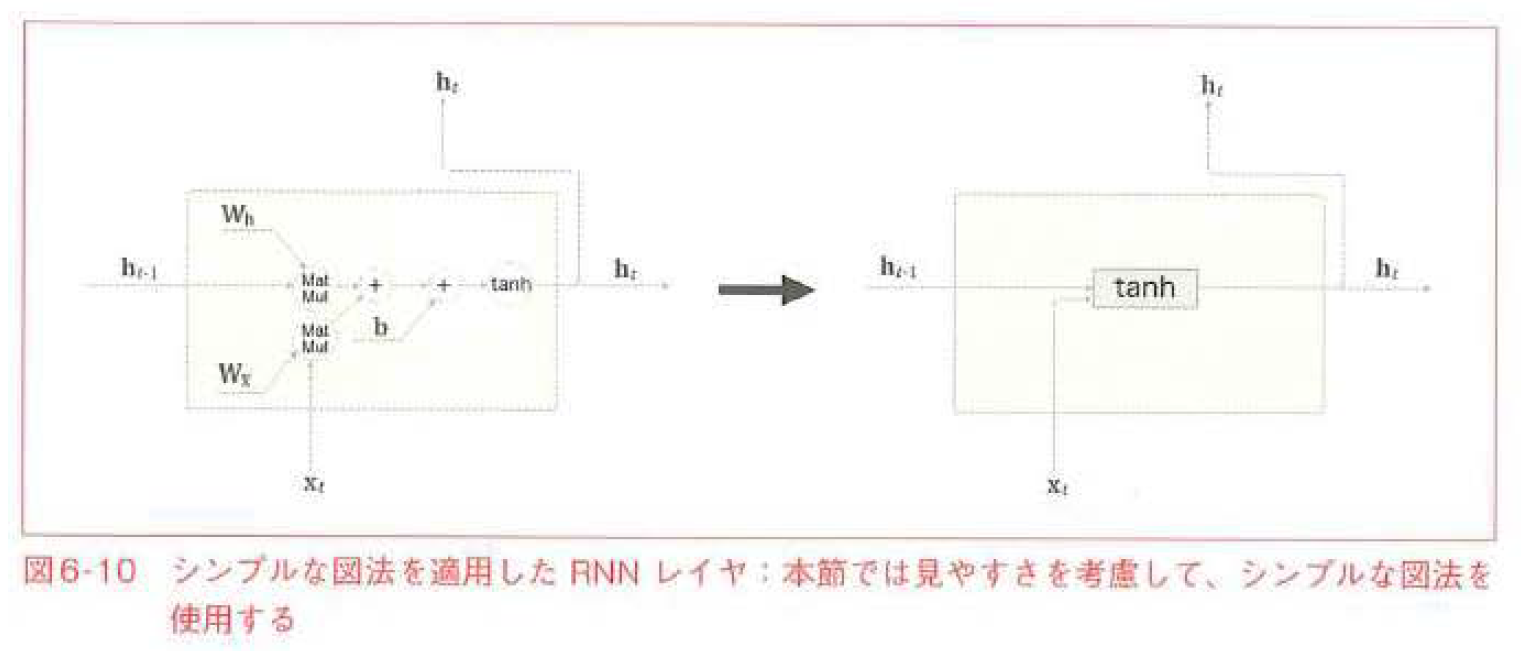

RNNとLSTMの違いは、LSTMには「c」というLSTM専用の「記憶セル」の経路が存在する

「c」ではLSTM内で完結するデータの受け渡しが行われるが、

「h」はRNNレイヤと同じく別のレイヤへ出力される

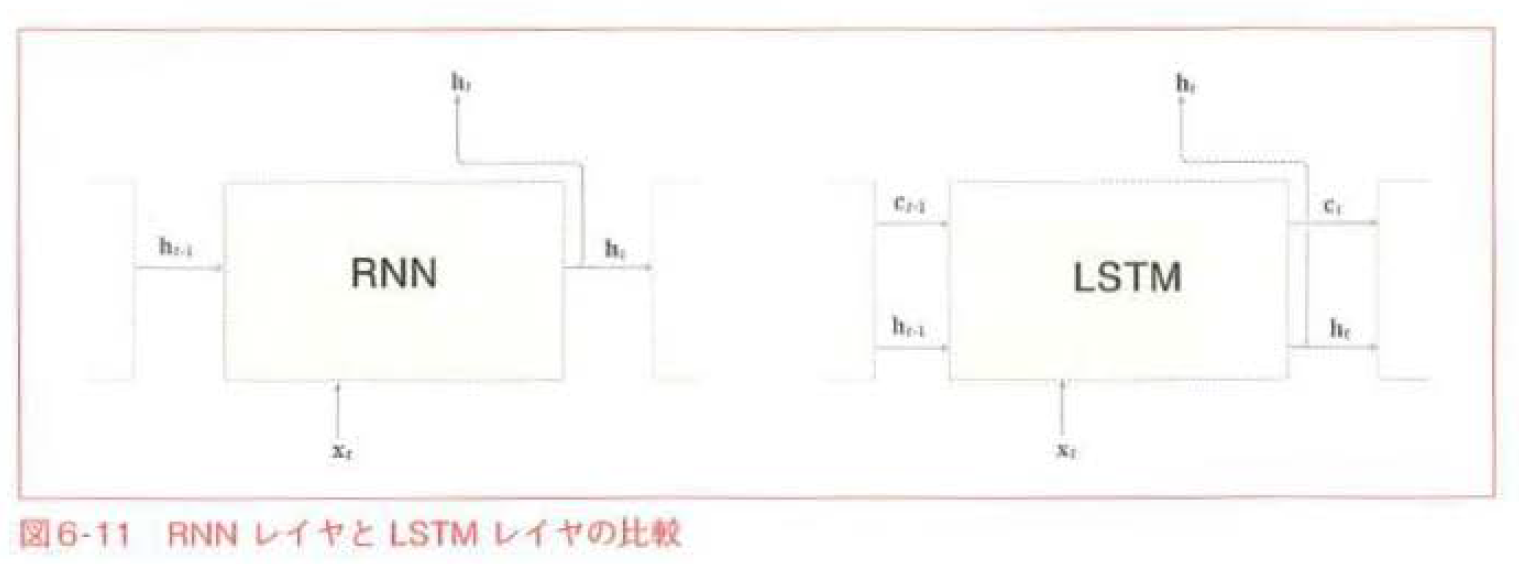

### 6.2.2 LSTMレイヤの組み立て

時刻tまでにおけるLSTMの記憶が格納されているc_tを元に、外部のレイヤへh_tを出力する

h_t＝tanh(c_t)によって計算される

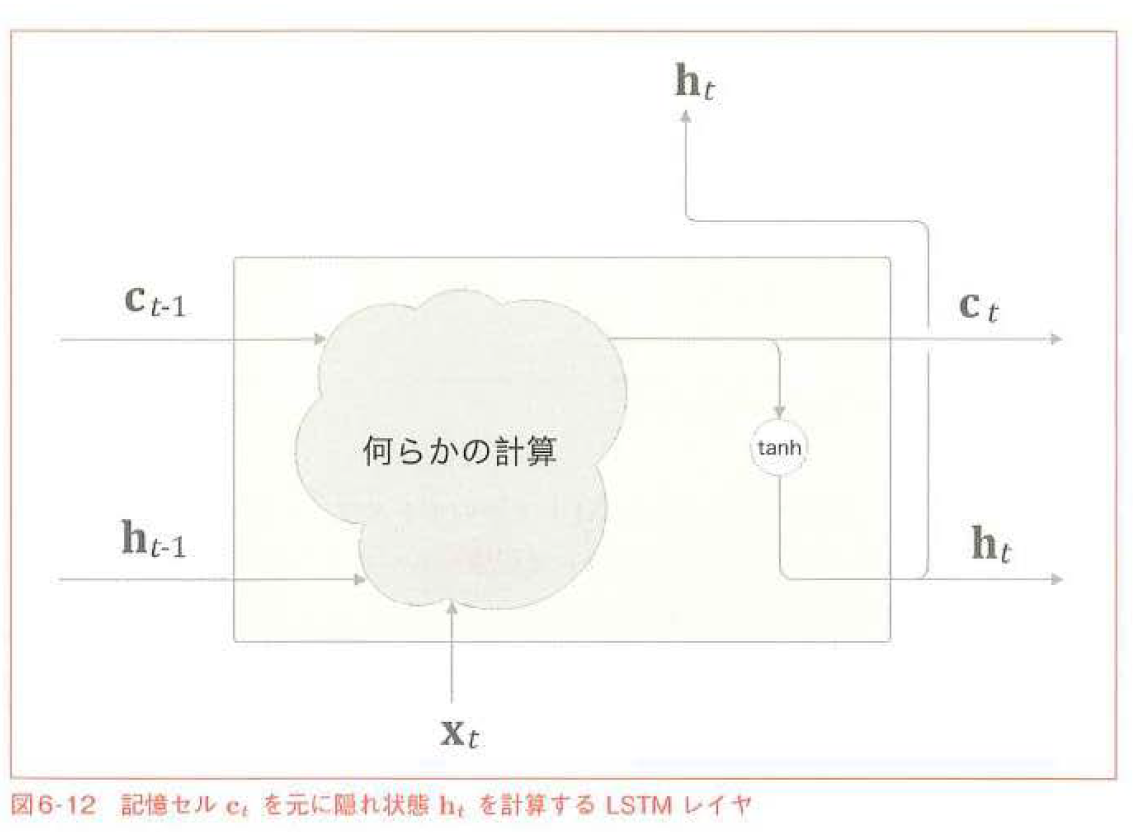

### ゲート

「開く/閉じる」のようにデータの流れをコントロール

さらに、どのくらい流すか、といった「開き具合」もコントロール

0.0～1.0で開き具合を表し、どれだけゲートを開くかもデータから学習する

### 6.2.3 outputゲート

tanh(c_t)の各要素にゲートを適用

h_t＝o◉tanh(c_t)（アダマール積...要素毎の積）

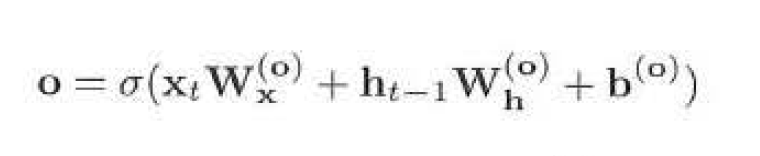

### 6.2.4 forgetゲート

記憶セルに対して「何を忘れるか」を指示

c_t-1の記憶から不要な記憶を忘れるためのゲートを追加

これを「forgetゲート」という



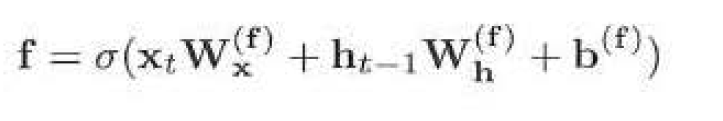

### 6.2.5 新しい記憶セル

新しく覚える情報を記憶セルに追加→「g」で表す

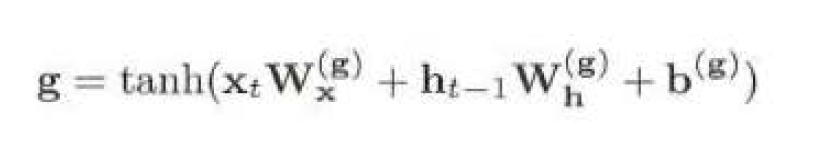

### 6.2.6 inputゲート

さきほどの「g」にゲートを追加

追加するゲートをinputゲートという→inputゲートを「σ」、出力をi

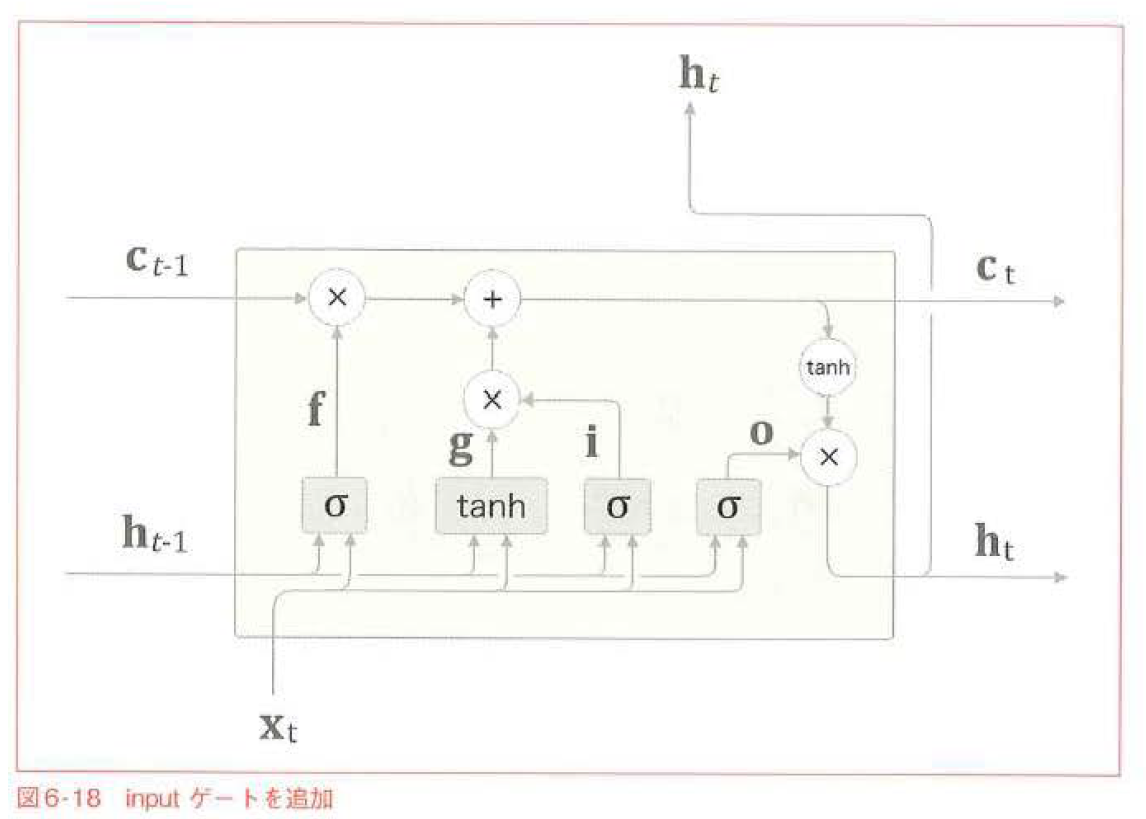

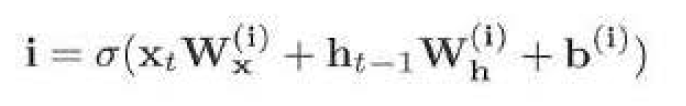

### 6.2.7 LSTMの勾配の流れ

勾配消失を起こさない(起きにくい)理由

①記憶セルだけにフォーカスすると、逆伝播では「＋」「×」だけを通り、「＋」では勾配の変化（劣化）が起きない

②「×」も今回「行列の積」ではなく「要素ごとの積(アダマール積)」を用いているため、毎時刻、異なるゲート値によって積の計算が行われる

③「忘れるべき」要素に対しては勾配が小さくなるが、「忘れてはいけない」要素は劣化すること無く、過去方向へ伝わる

## 6.3 LSTMの実装

1ステップの処理をLSTMクラスとして、Ｔステップ分の処理をTimeLSTMとして実装

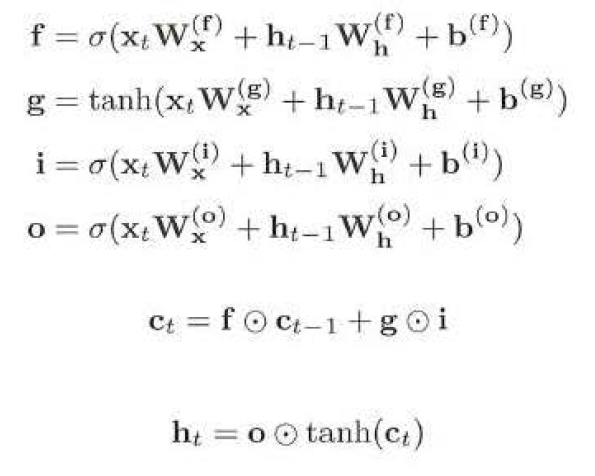

アフィン変換→xＷ_x＋hＷ_h＋b

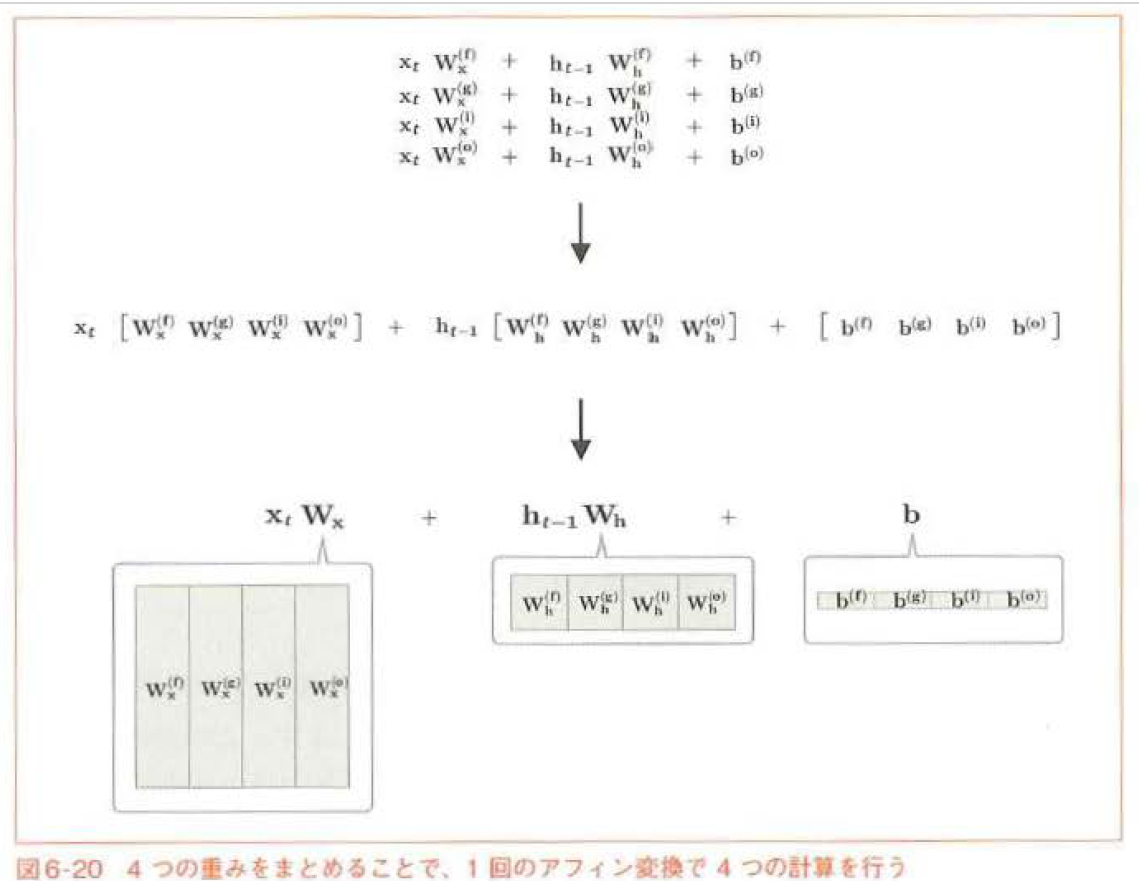

4つの重みを1つにまとめることで、4回個別に行っていたアフィン変換の計算を1回の計算で済ませる

多くの場合行列ライブラリは「大きな行列」としてまとめて計算した方が速くなる

初めに4つ分のアフィン変換を行い、

sliceノードによって結果を取り出す

その後、活性化関数を通る



LSTMクラスの実装

初期化の引数は、重みパラメータのＷ_xとＷ_h、バイアスのb

この引数で与えられたパラメータはメンバ変数の「params」に設定

メンバ変数の「cache」は順伝播の中間結果の保持に使用し、逆伝播でも使用する

In [10]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 入力`x`用の重みパラーメタ（4つ分の重みをまとめる）
        Wh: 隠れ状態`h`用の重みパラメータ（4つ分の重みをまとめる）
        b: バイアス（4つ分のバイアスをまとめる）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

順伝播の実装

引数は現入力のxと前時刻の隠れ状態h_prev、そして前時刻の記憶セルc_prevを受け取る

In [11]:
 def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

逆伝播

In [12]:
def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

### 6.3.1 TimeLSTMの実装

TimeRNNレイヤの要領で実装

In [13]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 LSTMを使った言語モデル

前章のTimeRNNの場所をTimeLSTMに変える

In [14]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()

PTBデータセットの学習を行う

Done
| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 9999.69
| epoch 1 |  iter 21 / 1327 | time 4[s] | perplexity 2965.95
| epoch 1 |  iter 41 / 1327 | time 7[s] | perplexity 1247.82
| epoch 1 |  iter 61 / 1327 | time 10[s] | perplexity 974.69
| epoch 1 |  iter 81 / 1327 | time 14[s] | perplexity 797.83
| epoch 1 |  iter 101 / 1327 | time 17[s] | perplexity 651.66
| epoch 1 |  iter 121 / 1327 | time 21[s] | perplexity 633.30
| epoch 1 |  iter 141 / 1327 | time 24[s] | perplexity 605.31
| epoch 1 |  iter 161 / 1327 | time 27[s] | perplexity 560.43
| epoch 1 |  iter 181 / 1327 | time 31[s] | perplexity 583.68
| epoch 1 |  iter 201 / 1327 | time 34[s] | perplexity 510.98
| epoch 1 |  iter 221 / 1327 | time 37[s] | perplexity 497.23
| epoch 1 |  iter 241 / 1327 | time 41[s] | perplexity 450.74
| epoch 1 |  iter 261 / 1327 | time 44[s] | perplexity 471.54
| epoch 1 |  iter 281 / 1327 | time 48[s] | perplexity 459.39
| epoch 1 |  iter 301 / 1327 | time 51[s] | perplexity 389.08
| epoch 1

| epoch 2 |  iter 1261 / 1327 | time 422[s] | perplexity 124.08
| epoch 2 |  iter 1281 / 1327 | time 425[s] | perplexity 123.46
| epoch 2 |  iter 1301 / 1327 | time 428[s] | perplexity 157.24
| epoch 2 |  iter 1321 / 1327 | time 432[s] | perplexity 151.97
| epoch 3 |  iter 1 / 1327 | time 433[s] | perplexity 159.30
| epoch 3 |  iter 21 / 1327 | time 436[s] | perplexity 143.27
| epoch 3 |  iter 41 / 1327 | time 440[s] | perplexity 136.05
| epoch 3 |  iter 61 / 1327 | time 443[s] | perplexity 127.47
| epoch 3 |  iter 81 / 1327 | time 447[s] | perplexity 116.81
| epoch 3 |  iter 101 / 1327 | time 450[s] | perplexity 105.05
| epoch 3 |  iter 121 / 1327 | time 453[s] | perplexity 116.67
| epoch 3 |  iter 141 / 1327 | time 457[s] | perplexity 125.46
| epoch 3 |  iter 161 / 1327 | time 460[s] | perplexity 140.98
| epoch 3 |  iter 181 / 1327 | time 463[s] | perplexity 151.09
| epoch 3 |  iter 201 / 1327 | time 467[s] | perplexity 139.59
| epoch 3 |  iter 221 / 1327 | time 470[s] | perplexity 1

| epoch 4 |  iter 1201 / 1327 | time 853[s] | perplexity 83.17
| epoch 4 |  iter 1221 / 1327 | time 856[s] | perplexity 76.21
| epoch 4 |  iter 1241 / 1327 | time 859[s] | perplexity 91.97
| epoch 4 |  iter 1261 / 1327 | time 863[s] | perplexity 92.67
| epoch 4 |  iter 1281 / 1327 | time 866[s] | perplexity 89.48
| epoch 4 |  iter 1301 / 1327 | time 870[s] | perplexity 110.29
| epoch 4 |  iter 1321 / 1327 | time 874[s] | perplexity 110.98


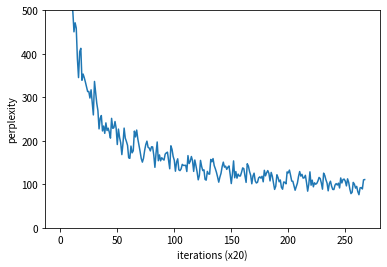

evaluating perplexity ...
234 / 235
test perplexity:  134.82031439979366


In [16]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from rnnlm import Rnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 35  # RNNを展開するサイズ
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

## 6.5 RNNLMのさらなる改善



### 6.5.1 LSTMレイヤの多層化

PTBデータセットの言語モデルの場合は、LSTMの層数は2～4程度が良い

### 6.5.2 Dropoutによる過学習の抑制

層を増やすとより起こりやすくなる

過学習の抑制のためには、「訓練データを増やす」「モデルの複雑さを減らす」

そこで「正則化」を用いる

訓練時のレイヤ内のニューロンの何％かをランダムに無視して学習を行うことは「正則化」の一種で、Dropoutという

時間方向ではなく深さ方向に対してDropoutレイヤを挿入する

### 6.5.3 重み共有

Embeddingレイヤの重みとAffineレイヤの重みを結びつける

これにより学習するパラメータを減らすことができる

具体的には、Embeddingレイヤの重みの転置をAffineレイヤの重みに設定する

#### 6.5.4 より良いRNNLMの実装



In [17]:
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTMレイヤを2層利用し、各層にDropoutを使うモデル
     [1]で提案されたモデルをベースとし、weight tying[2][3]を利用

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import sys
sys.path.append('..')
from common import config
# GPUで実行する場合は下記のコメントアウトを消去（要cupy）
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm


# ハイパーパラメータの設定
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 9999.90
| epoch 1 |  iter 21 / 1327 | time 44[s] | perplexity 5243.46
| epoch 1 |  iter 41 / 1327 | time 79[s] | perplexity 1636.90
| epoch 1 |  iter 61 / 1327 | time 112[s] | perplexity 1280.62
| epoch 1 |  iter 81 / 1327 | time 145[s] | perplexity 1073.32
| epoch 1 |  iter 101 / 1327 | time 179[s] | perplexity 856.93
| epoch 1 |  iter 121 / 1327 | time 218[s] | perplexity 795.43
| epoch 1 |  iter 141 / 1327 | time 264[s] | perplexity 717.77
| epoch 1 |  iter 161 / 1327 | time 306[s] | perplexity 685.07
| epoch 1 |  iter 181 / 1327 | time 342[s] | perplexity 674.71
| epoch 1 |  iter 201 / 1327 | time 384[s] | perplexity 602.14
| epoch 1 |  iter 221 / 1327 | time 422[s] | perplexity 578.22
| epoch 1 |  iter 241 / 1327 | time 470[s] | perplexity 511.88
| epoch 1 |  iter 261 / 1327 | time 511[s] | perplexity 539.56
| epoch 1 |  iter 281 / 1327 | time 555[s] | perplexity 512.72
| epoch 1 |  iter 301 / 1327 | time 594[s] | perplexity 454.

## 6.6 まとめ

● 単純なRNNの学習では、勾配消失・勾配爆発が問題になる

● 勾配爆発には勾配クリッビング、勾配消失にはLSTMやGRUなどの
ゲート付きRNNが有効である

● LSTMには、inputゲート、forgetゲート、outputゲートの3つのゲー
トがある

● ゲートには専用の重みがあり、sigmoid関数を使って0.0から1.0までの実数を出力する

● 言語モデルの改善には、LSTMレイヤの多層化、Dropout、重み共有などのテクニックが有効である

● RNNの正則化は重要なテーマであり、Dropoutベースのさまざまな手法が提案されている